In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['MAE', 'MSE', 'R²']
before_optimization = [30644.353856213715, 2055466293.6155949, 0.8439003754715834]
after_optimization = [28720.570817017142, 1912805105.6602802, 0.8547345876130193]

normalized_mse_before = before_optimization[1] / 1e9  
normalized_mse_after = after_optimization[1] / 1e9

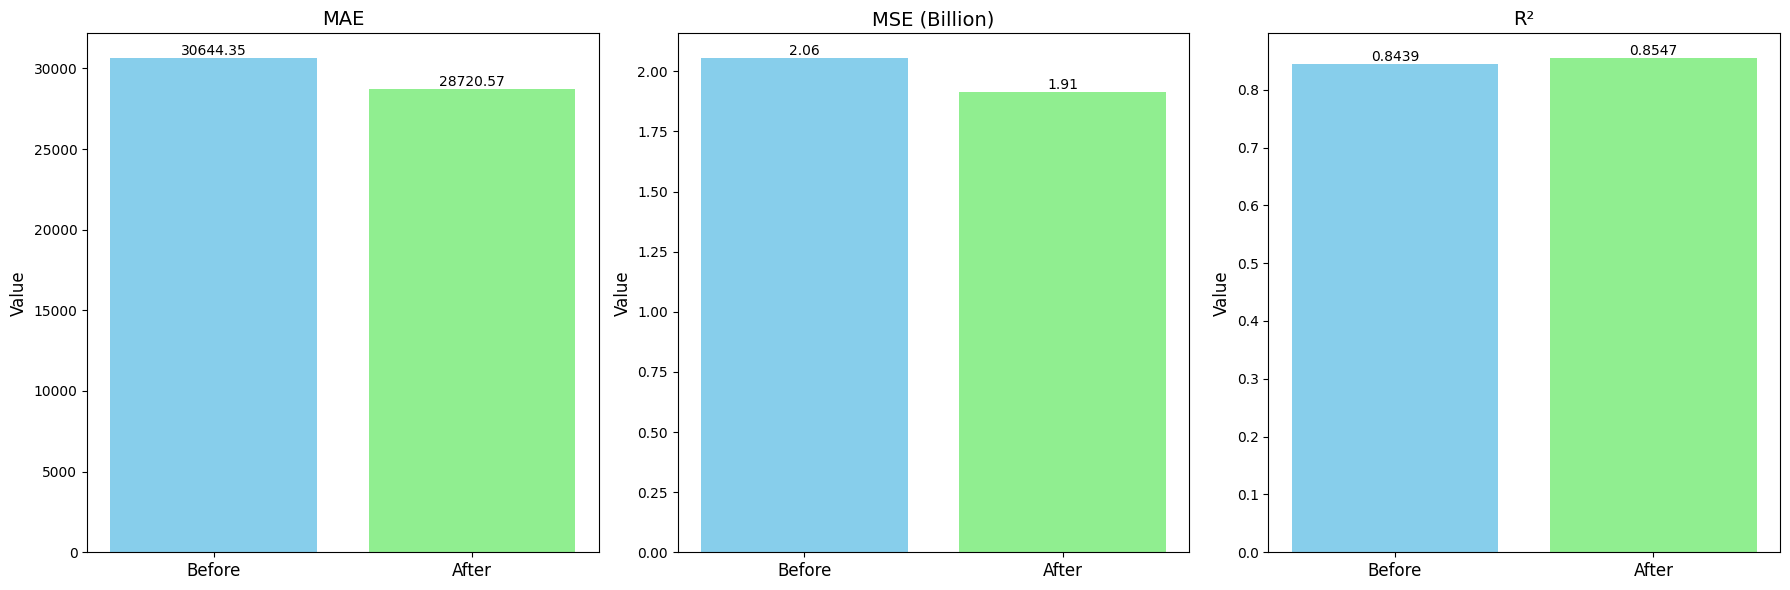

In [ ]:
# Data for each metric
metrics_individual = ['MAE', 'MSE (Billion)', 'R²']
before_values = [before_optimization[0], normalized_mse_before, before_optimization[2]]
after_values = [after_optimization[0], normalized_mse_after, after_optimization[2]]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each metric and create individual plots
for i, ax in enumerate(axes):
    ax.bar(['Before', 'After'], [before_values[i], after_values[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics_individual[i], fontsize=14)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Before', 'After'], fontsize=12)
    
    # Annotate bars
    for j, value in enumerate([before_values[i], after_values[i]]):
        ax.text(j, value, f'{value:.2f}' if i < 2 else f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

train_info = train_data.info(), train_data.head()
val_info = val_data.info(), val_data.head()
test_info = test_data.info(), test_data.head()

train_info, val_info, test_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  float64
 9   median_house_value  16512 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064 entries, 0 to 2063
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           2064 non-null   float64

((None,
     longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
  0   1.272587 -1.372811            0.348490     0.222569        0.211228   
  1   0.709162 -0.876696            1.618118     0.340293        0.593094   
  2  -0.447603 -0.460146           -1.952710    -0.342597       -0.495226   
  3   1.232698 -1.382172            0.586545    -0.561490       -0.409306   
  4  -0.108551  0.532084            1.142008    -0.119565       -0.256559   
  
     population  households  median_income  ocean_proximity  median_house_value  
  0    0.768276    0.322906      -0.326196         1.809022              103000  
  1   -0.098901    0.672027      -0.035843         1.809022              382100  
  2   -0.449818   -0.430461       0.144701         1.809022              172600  
  3   -0.007434   -0.380587      -1.017864         1.809022               93400  
  4   -0.485877   -0.314962      -0.171488         0.636109               96500  ),
 (None,
     longitude  latitude 

Chạy thử với CatBoost

In [10]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

X_train = train_data.drop(columns=["median_house_value"])
y_train = train_data["median_house_value"]

X_val = val_data.drop(columns=["median_house_value"])
y_val = val_data["median_house_value"]

X_test = test_data.drop(columns=["median_house_value"])
y_test = test_data["median_house_value"]

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = CatBoostRegressor(iterations=1000, learning_rate=0.5, depth=6, silent=True)
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

val_predictions = model.predict(X_val)

mae = mean_absolute_error(y_val, val_predictions)
mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

MAE: 30644.353856213715
MSE: 2055466293.6155949
R²: 0.8439003754715834


Tôi ưu bằng Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

model = CatBoostRegressor(silent=True)

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [1, 3, 5]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Kết quả tối ưu
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best MSE Score:", best_score)

Best Parameters: {'depth': 8, 'iterations': 1500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best MSE Score: 2077016791.3945296


In [12]:
optimal_model = CatBoostRegressor(**best_params, silent=True)
optimal_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

Sau khi tối ưu

In [14]:
val_predictions = optimal_model.predict(X_val)

mae = mean_absolute_error(y_val, val_predictions)
mse = mean_squared_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

MAE: 28720.570817017142
MSE: 1912805105.6602802
R²: 0.8547345876130193
